## <center>Classificador de Notícias Falsas</center>

---
### Objetivo

Este notebook tem como objetivo construir um classificador que identifique se uma notícia é confiável ou não, com base nos dados fornecidos para treinamento. 

Além disso, os dados fornecidos no arquivo **test_data** serão classificados e enviados em uma competição na plataforma **kaggle**. Portanto, é importante ressaltar que o classificador foi construido com o objetivo de obter o melhor desempenho nesta competição.

---
### Análise exploratória

In [1]:
# Importa bibliotecas necessárias
import pandas as pd
import glob
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
# Realiza a leitura das notícias
files = glob.glob('data/news*.csv')

news_data_list = []

for file in files:
    news_data_list.append(pd.read_csv(file))

news_data = pd.concat(news_data_list, ignore_index=True)

A célula de código abaixo mostra as 5 primeiras amostras para verificar se elas foram carregadas corretamente e também como está organizada a base de dados.

In [3]:
news_data.head(5)

,id,title,content,date
0,id-1070176,Five signings Man City could make to cure thei...,"In World Cup winner Benjamin Mendy , Man City ...",2019-01-16
1,id-1072326,How hackers could have stolen your seats or ca...,PASSENGERS travelling with one of 141 internat...,2019-01-17
2,id-1062508,"Onimusha: Warlords review | Switch, PS4 and Xb...",At times it can feel that Capcom ’ s samurai a...,2019-01-15
3,id-1080550,From bins bedlam to Brexit - an eventful year ...,The Local Democracy Reporting Scheme is markin...,2019-01-18
4,id-1114787,New York Aborted More Babies In Three Years Th...,New York saw more abortions in a three-year ti...,2019-01-26


Como pode-se observar abaixo, temos uma grande quantidade de dados (mais de 2 milhões de amostras de notícias) para analisar, cada um com 4 atributos.

In [4]:
print('Quantidade de amostras:', news_data.shape[0])
print('Colunas:', news_data.shape[1])

Quantidade de amostras: 2115592
Colunas: 4


Para começar a análise exploratória dos dados, é preciso separar as notícias classificadas e que serão utilizadas para treino das notícias que serão avaliadas na competição.

In [3]:
# Separa as notícias que serão analisadas e utilizadas para treinamento
train_data = pd.read_csv('data/train.csv')
train_data = train_data.merge(news_data, on='id', how='inner')

In [4]:
# Separa as notícias utilizadas para submissão no kaggle
kaggle_data = pd.read_csv('data/test.csv')
kaggle_data = kaggle_data.merge(news_data, on='id', how='inner')

Antes de tudo, é preciso deixar claro quais os atributos dos dados e o significado de cada um:

* `id`: É o atributo utilizado para identificar unicamente cada uma das notícias.
* `title`: Representa o título da notícia.
* `content`: Diz respeito ao conteúdo, ou texto, da notícia.
* `date`: Corresponde a data de publicação.
* `label`: Representa a classificação da notícia, sendo cada uma classificada como não confiável (1) ou confiável (0).
    
Apenas os dados de treino possuem o atributo label que classifica a notícia, uma vez que os dados da competição - **kaggle_data** - são dados que ainda precisam ser classificados na tarefa. 

In [7]:
# Mostra os atributos dos dados de treino e kaggle, respectivamente
display(train_data.columns)
display(kaggle_data.columns)

Index(['id', 'label', 'title', 'content', 'date'], dtype='object')

Index(['id', 'title', 'content', 'date'], dtype='object')

Primeiro, para analisar as notícias, podemos criar um gráfico que mostra a quatidade de notícias falsas (1) e verdadeiras (0). 

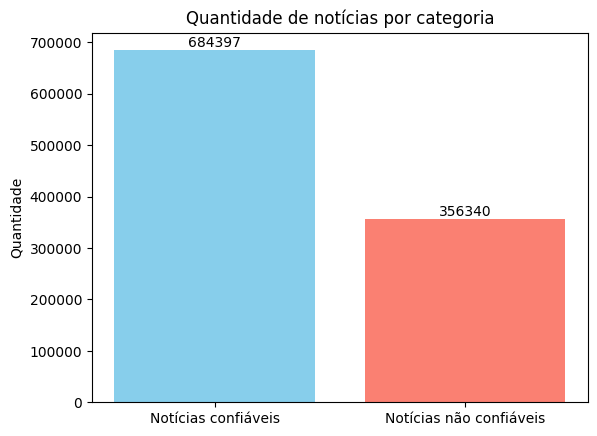

In [8]:
from scripts.analise_exploratoria import show_count_by_label
show_count_by_label(train_data)

De um modo geral, pode-se observar que existem mais notícias confiáveis do que *fake news* na base de dados como um todo.

A quantidade de valores nulos que a base de dados possui também é uma informação relevante, uma vez que algoritmos de aprendizado de máquina não podem lidar diretamente com eles. Assim, é preciso realizar um tratamento prévio, como preenchimento ou remoção desses valores.

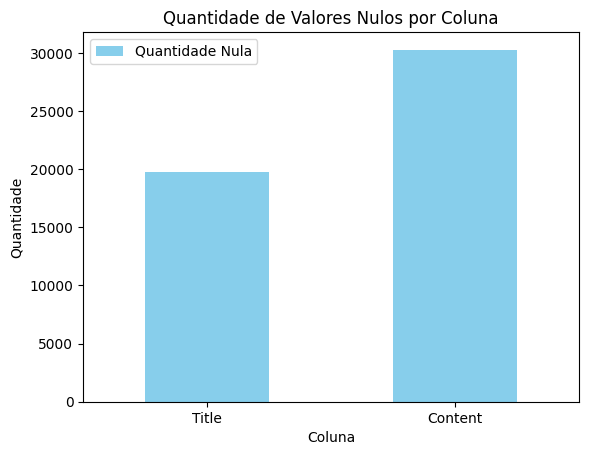

In [5]:
from scripts.analise_exploratoria import show_null
show_null(train_data)

Distribuição temporal dos dados: A distribuição temporal dos dados mostra a distribuição das notícias, em relação a sua classificação, de acordo com o ano de publicação. Isso possibilita verificar como elas se comportam ao longo do tempo e se a data é relevante para a classificação.

Como demonstrado no gráfico abaixo, tivemos uma quantidade muito maior de notícias confiáveis em relação a notícias não-confiáveis no ano de 2019. Por outro lado, em 2020 o número de notícias em cada categoria foi muito próximo, o que indica que **date** é um atributo muito relevante para o problema.

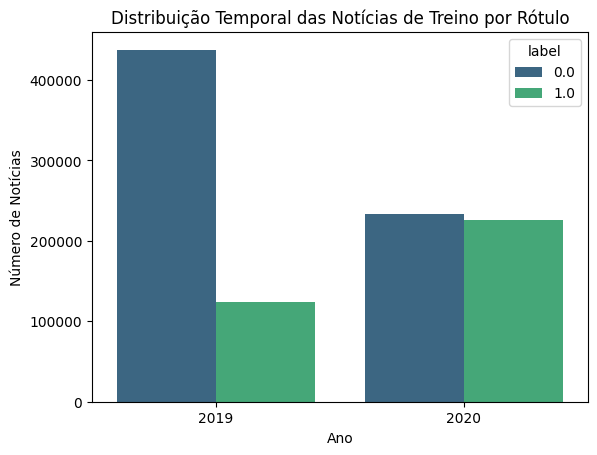

In [9]:
from scripts.analise_exploratoria import show_temporal_by_label
show_temporal_by_label(train_data, 800, title='Distribuição Temporal das Notícias de Treino por Rótulo')

Devido a essa distribuição diferente das categorias nos 2 anos, é importante verificar a qual data os dados que serão classificados na competição pertencem, com a finalidade de obter um modelo de classificação que generalize bem para estes dados.

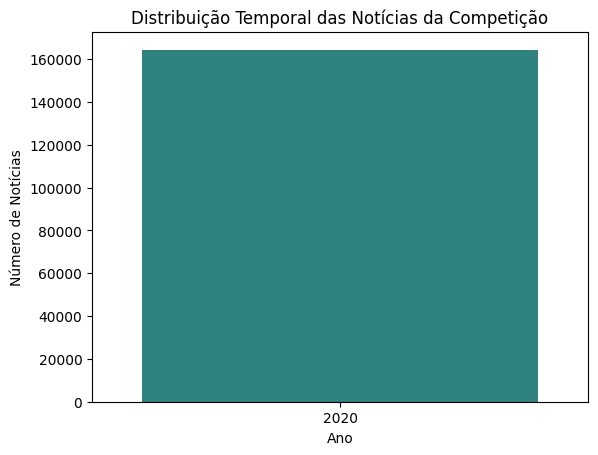

In [10]:
from scripts.analise_exploratoria import show_temporal
show_temporal(kaggle_data, 800, title='Distribuição Temporal das Notícias da Competição')

In [11]:
# Exibe o percentual de notícias que são de 2020
count_data = kaggle_data.groupby(['year']).size().reset_index(name='count')
percent_2020 = (count_data[count_data['year'] == 2020]['count'] / kaggle_data.shape[0]) * 100
percent_2020 = percent_2020.values[0]

print(f'{percent_2020:.2f}% das notícias são de 2020.')

98.03% das notícias são de 2020.


Conforme evidenciado acima, as notícias que serão classificadas e enviadas no **kaggle** são, aproximadamente, todas do ano de 2020. Dessa forma, como a distribuição das classes no ano de 2020 foi aproximadamente igual, para conseguir uma melhor capacidade de generalização a decisão tomada foi a de realizar o treinamento do modelo apenas com as notícias de 2020.

Outra análise interessante que pode ser realizada é a geração de **wordclouds**, que mostram as palavras mais frequentes nas notícias. Na célula abaixo foi gerada uma núvem de texto para o título das notícias. 

Esse método é muito utilizado por permitir uma rápida percepção das palavras-chave em um determinado texto. Assim, é possível ter uma boa compreensão dessas palvras de forma fácil e visual.

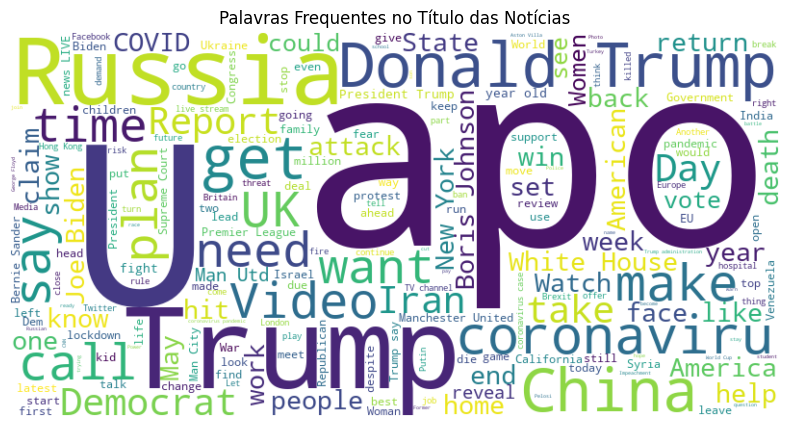

In [12]:
from scripts.analise_exploratoria import generate_wordcloud

title = train_data['title'].dropna()
generate_wordcloud(' '.join(w for w in title), 'Palavras Frequentes no Título das Notícias')

De acordo com a núvem, podemos ver que algumas das palavras mais frequentes e relevantes nos títulos são: **Trump**, **coronavirus**, **Russia** e **China**, o que indica um forte viés político nas notícias.

---
### Pré-processamento

Como os modelos serão treinados apenas com dados de 2020, o bloco de código abaixo filtra os dados de treino para que apenas essas notícias sejam utilizadas.

In [13]:
# Filtra dos dados de treino apenas os dados que são do ano de 2020
train_data['date'] = pd.to_datetime(train_data['date'])
train_data['year'] = train_data['date'].dt.year
train_data = train_data[train_data['year'] == 2020]

Após a filtragem, são removidos da base de treino os dados não rotulados, ou seja, que não possuem uma classificação, assim como os que possuem título e/ou conteúdo nulos. Além disso, a coluna **date** é removida de ambas as bases, uma vez que não será mais utilizada, e a coluna **year** adicionada para filtrar as notícias de treino também.

In [14]:
# Remove a coluna data e year e as notícias não rotuladas de train_data, além dos dados que possuem título e/ou conteúdo nulos
train_data = train_data.drop(['date', 'year'], axis=1)
train_data = train_data.dropna(subset=['content', 'title', 'label'])

In [15]:
# Removendo a coluna data de kaggle_data
kaggle_data = kaggle_data.drop(['date'], axis=1)

Abaixo, é feita a junção em ambas as bases das colunas que representam o título e o conteúdo das notícias em uma só coluna chamada **text**.

In [16]:
# Realizando a junção das colunas title e content
train_data['text'] = train_data['title'] + ' ' + train_data['content']
kaggle_data['text'] = kaggle_data['title'] + ' ' + kaggle_data['content']

train_data = train_data.drop(['content', 'title'], axis=1)
kaggle_data = kaggle_data.drop(['content', 'title'], axis=1)

Após esses procedimentos, será aplicada no texto das amostras uma função que realiza diversas operações, tais como a normalização de números, URLs, e-mails e símbolos, remoção de *stopwords* e tags HTML, conversão de caracteres não-alfanuméricos em espaço e conversão do texto para letra minúscula.

In [ ]:
# Aplicando um pré-processamento no texto e título das respectivas notícias, com a finalidade de melhorar o desempenho do algoritmo
from scripts.preprocessamento import preprocessing
import nltk

nltk.download('stopwords')
nltk.download('punkt')

# Pré-processamento dos dados de treino
train_data.loc[:, 'text'] = train_data['text'].apply(preprocessing)

In [18]:
# Pré-processamento dos dados não rotulados (kaggle)
kaggle_data.loc[:, 'text'] = kaggle_data['text'].apply(preprocessing)

Após a aplicação deste processamento textual, podemos ver que os dados já se encontram da forma desejada. 

In [19]:
display(train_data.head(5))
display(kaggle_data.head(5))

,id,label,text
1118838,id-2118838,1.0,jacqueline jossa reveals sneak preview inthest...
1118842,id-2118842,1.0,mcdonald boosts coffee loyalty scheme get two ...
1118843,id-2118843,0.0,china monumental year welcome foreign policy c...
1118847,id-2118847,1.0,brits ring new year london biggest ever firewo...
1118848,id-2118848,1.0,five new number coins revealed including day o...


,id,year,text
0,id-3378296,2020,watch live kayleigh mcenany holds white house ...
1,id-3138916,2020,phil collins funny moment post sent check emai...
2,id-3304259,2020,house panel investigating postmaster general g...
3,id-3381436,2020,trump commit peaceful transfer power loses wel...
4,id-3594175,2020,ap photos worldly concerns bleed spiritual rea...


Por fim, para transformar os dados textuais em uma matriz numérica e possibilitar o treinamento dos modelos de AM foi aplicado o **TfidfVectorizer**, uma função do **sklearn** muito útil para processamento de linguagem natural. Aqui está uma breve explicação de como este método funciona:
* `TF`: Representa a frequência de cada palavra em um documento, calculada simplesmente pelo número de vezes em que o termo aparece.
* `IDF`: Calcula a importância de uma palavra em todo o conjunto de documentos. O objetivo é dar maior peso aos termos que são raros em todo o conjunto de documentos, mas comuns em documentos específicos.
* `TF-IDF`: O TF-IDF é a multiplicação da frequência do termo (TF) e a frequência inversa do documento (IDF). Isso significa que os termos que ocorrem com frequência em um documento específico, mas raramente em outros documentos, terão uma pontuação TF-IDF alta. Em contraste, os termos que ocorrem frequentemente em todos os documentos terão uma pontuação TF-IDF baixa.

Portanto, o **TfidfVectorizer** transforma cada documento de texto em um vetor numérico, onde cada elemento do vetor representa a pontuação TF-IDF de um termo específico no documento.

In [20]:
# Separa train_data em features e labels (só é necessário para o treinamento)
X = train_data.drop(columns='label', axis=1)
X = X['text'].values

y = train_data['label']
y = y.values

# Obtém a coluna 'text' de kaggle_data e transforma ela em uma matriz NumPy
kaggle_data = kaggle_data['text'].values

In [21]:
# Instancia a classe do sklearn que realiza a conversão do texto em uma matriz numérica
vectorizer = TfidfVectorizer()
vectorizer.fit(X)  # Aprende o vocabulário dos dados

# Converte o texto de X com a função do sklearn
X = vectorizer.transform(X)

Para que não seja necessário realizar o pré-processamento novamente, os dados processados foram salvos na pasta **processed_data** e podem ser recuperados facilmente com a biblioteca **pickle**.

In [22]:
import pickle

with open('processed_data/x.pkl', 'wb') as arquivo:
    pickle.dump(X, arquivo)
    
with open('processed_data/y.pkl', 'wb') as arquivo:
    pickle.dump(y, arquivo)

In [2]:
# Carrega arquivos x e y (caso já estejam salvos)
import pickle

with open('processed_data/x.pkl', 'rb') as arquivo:
    X = pickle.load(arquivo)

with open('processed_data/y.pkl', 'rb') as arquivo:
    y = pickle.load(arquivo)

O mesmo é feito com os dados da competição, com a diferença de que agora o vocabulário não é aprendido novamente.

In [24]:
# Converte o texto de kaggle_data em uma matriz numérica com a função do sklearn
kaggle_processed_data = vectorizer.transform(kaggle_data)

In [25]:
# Salva kaggle_processed_data (dados que devem ser classificados e enviados na competição)
import pickle

with open('processed_data/kaggle_processed.pkl', 'wb') as arquivo:
    pickle.dump(kaggle_processed_data, arquivo)

In [4]:
# Carrega arquivo kaggle_processed (caso já esteja salvo)
import pickle

with open('processed_data/kaggle_processed.pkl', 'rb') as arquivo:
    kaggle_processed_data = pickle.load(arquivo)

---
### Experimentos

Durante os experimentos, para que os modelos sejam todos testados com o mesmo conjunto de teste, foi realizada uma separação da base de dados em 80% para treino e 20% para teste.

In [3]:
# Separa os dados de treinamento em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

print('Quantidade de dados para treino:', X_train.shape[0])
print('Quantidade de dados para teste:', X_test.shape[0])

Quantidade de dados para treino: 355828
Quantidade de dados para teste: 88958


Neste projeto, foram avaliados 3 métodos de aprendizado de máquina: 
* `Regressão Logística`: É um algoritmo de classificação utilizado para prever a probabilidade de uma amostra pertencer a uma ou mais classes. A saída da regressão logística é um valor que varia entre 0 e 1 (a classe é atribuída com base em determinado limiar).
* `Árvore de decisão`: Consite em um método de aprendizado de máquina que funciona construindo uma estrutura de árvore em que cada nó interno representa uma "decisão" e cada folha um rótulo de classificação.
* `Naive Bayes`: É um algoritmo de classificação baseado no teorema de Bayes que calcula a probabilidade de cada classe, dada uma instância de entrada, e seleciona a classe com a maior pontuação. O Naive Bayes é amplamente utilizado em tarefas de classificação de texto, como categorização de e-mails ou análise de sentimentos.

Em todos, foi realizada uma busca pelos melhores hiperparâmetros com a função **GridSearchCV**. 

In [ ]:
from scripts.experimentos import train_logistic_regression

model_logistic_regression = train_logistic_regression(X_train, y_train)  # Treina o modelo com a busca de parâmetros
joblib.dump(model_logistic_regression, 'models/model_logistic_regression.joblib')  # Salva o modelo

In [29]:
from scripts.experimentos import train_decision_tree

model_decision_tree = train_decision_tree(X_train, y_train)
joblib.dump(model_decision_tree, 'models/model_decision_tree.joblib')

In [ ]:
from scripts.experimentos import train_bayes

model_bayes = train_bayes(X_train, y_train)
joblib.dump(model_bayes, 'models/model_bayes.joblib')

Para recuperar os modelos, caso eles já estejam salvos, basta executar a célula de código abaixo.

In [4]:
model_logistic_regression = joblib.load('models/model_logistic_regression.joblib')  # Recupera o modelo de Regressão Logística
model_bayes = joblib.load('models/model_bayes.joblib')  # Recupera o modelo Naive Bayes
model_decision_tree = joblib.load('models/model_decision_tree.joblib')  # Recupera o modelo Árvore de Decisão

---
### Análise dos Resultados

In [5]:
models = [
    {'nome': 'Regressão Logística', 'modelo': model_logistic_regression},
    {'nome': 'Naive Bayes', 'modelo': model_bayes},
    {'nome': 'Árvore de Decisão', 'modelo': model_decision_tree}
]

Na célula de execução a seguir, os modelos são avaliados de acordo com sua acurácia e AUC (area under the roc curve). O melhor desemepenho obtido foi o da **Regressão Logística**, seguido pelo **Naive Bayes** e, por fim, a **Árvore de Decisão**.

In [7]:
# Acurácia dos modelos na base de teste.
from scripts.analise_resultados import eval_models
eval_models(models, X_test, y_test)

------------------------------ Regressão Logística ------------------------------
Acurácia: 0.8047
AUC (area under the ROC curve): 0.8889
---------------------------------- Naive Bayes ----------------------------------
Acurácia: 0.7547
AUC (area under the ROC curve): 0.8392
------------------------------- Árvore de Decisão -------------------------------
Acurácia: 0.7130
AUC (area under the ROC curve): 0.7126


Para uma melhor visualização dos resultados obtidos pelos métodos, o gráfico da figura abaixo exibe a curva ROC (Receiver Operator Characteristic) de cada um deles. A curva em questão é uma ferramenta eficaz para avaliar a capacidade de diagnóstico de classificadores binários, destacando a taxa de verdadeiros positivos em relação à taxa de falsos positivos. Evidentemente, o melhor desempenho a partir do gráfico foi novamente o da **Regressão Logística**, que possui o maior AUC (area under the ROC curve).

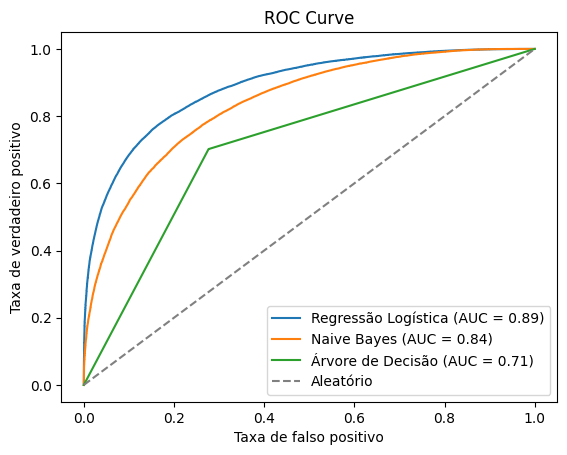

In [8]:
from scripts.analise_resultados import show_roc_curve
show_roc_curve(models, X_test, y_test)

Para finalizar a análise de resultados, podemos ver abaixo a matriz de confusão de cada um dos modelos. Essa matriz consiste em uma tabela que compara os rótulos reais das notícias com os rótulos previstos pelo modelo, sendo útil para gerar uma imagem mais completa do desempenho do modelo.

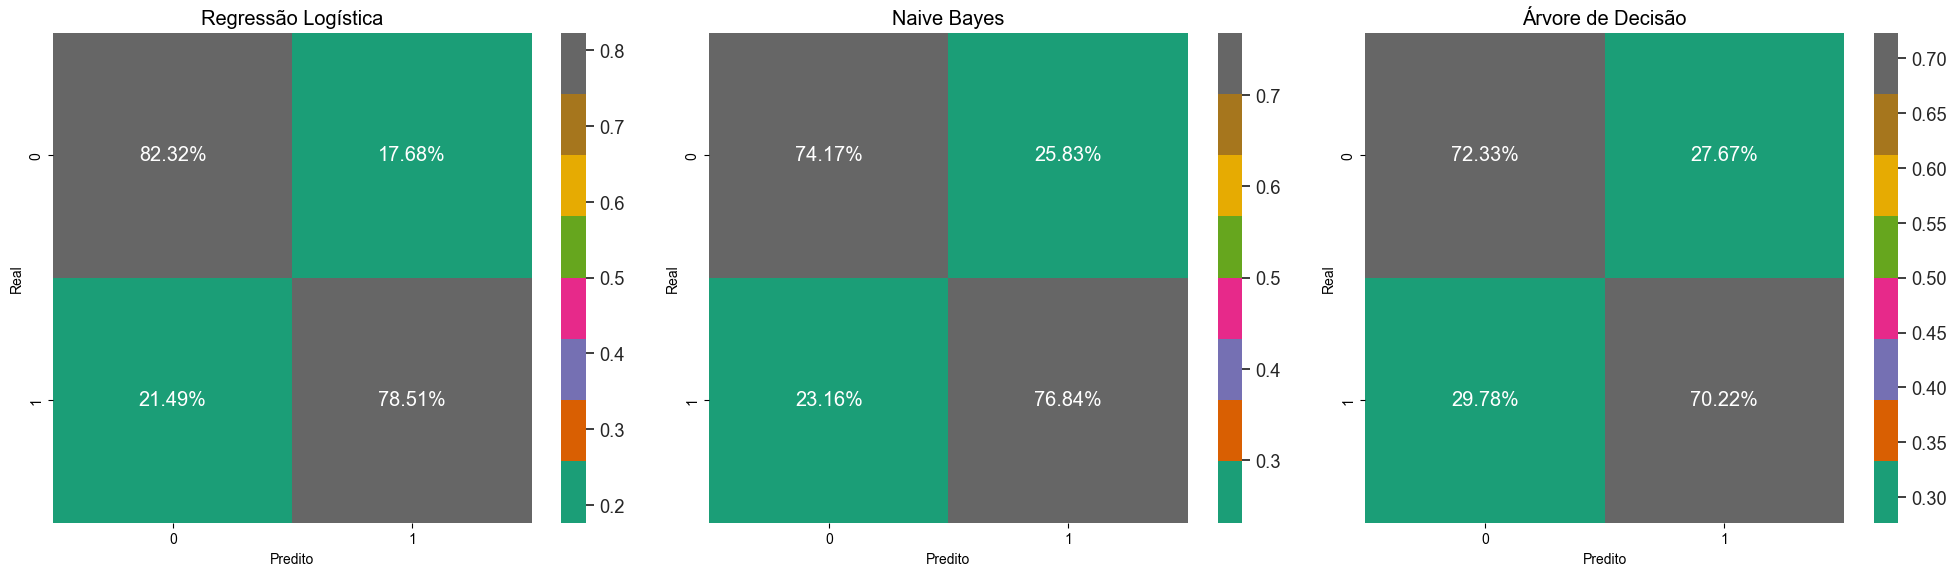

In [6]:
import matplotlib.pyplot as plt
from scripts.analise_resultados import plot_confusion_matrix

fig, axes = plt.subplots(1, len(models), figsize=(20, 6))

# Exibe uma matriz de confusão para cada um dos modelos testados
for i, model_info in enumerate(models):
    ax = axes[i] if len(models) > 1 else axes
    y_pred = model_info['modelo'].predict(X_test)
    plot_confusion_matrix(ax, y_test, y_pred, model_info['nome'])

plt.tight_layout()
plt.show()

De forma resumida, as áreas em que a matriz possui coloração cinza representam os acertos na predição da classe por parte do modelo. Por outro lado, áreas com coloração verde mostram em quando as classes foram preditas de forma incorreta. 

---
### Competição do Kaggle

O trecho de código abaixo treina um modelo de **Regressão Logística**, método que obteve o melhor desempenho, com 100% dos dados de treinamento para a submissão na competição.

In [16]:
# Cria o arquivo .csv para submeter na competição do kaggle.
model_submission = LogisticRegression(solver='sag', C=7)
model_submission.fit(X, y)

sub = pd.read_csv('data/test.csv')
sub['label'] = model_submission.predict_proba(kaggle_processed_data)[:, 1]
sub.to_csv('submission.csv', index=False)

---
### Conclusão

Em vista da grande quantidade de *fake news* na era digital, este projeto buscou abordar meios para detectar notícias não-confiáveis de forma precisa e automática através do aprendizado de máquina, empregado na extensa base de dados real disponível no **kaggle**.

A partir da análise exploratória dos dados, foi possível observar um grande aumento na quantidade de notícias falsas no ano de 2020 em relação a 2019. Além disso, a núvem de palavras gerada demonstrou um forte viés político nas notícias.

Os resultados destacaram a **Regressão Logísitca** como a abordagem mais eficaz e, considerando a complexidade do desafio, perspectivas futuras de trabalho podem explorar outros métodos mais elaborados de AM, como **Redes Neurais** e **Máquinas de Vetores de Suporte (SVM)**, que não foram utilizados devido a limitações de processamento computacinal e tempo. Esses modelos complexos envolvem cálculos matemáticos intensivos durante o processo de aprendizado e levam uma quantidade de tempo elevada no treinamento com grandes conjuntos de dados.